In [57]:
from classes import *
from utils import *
import math

from typing import List, Set, Tuple, Any, Dict, DefaultDict, Optional
from collections import defaultdict
import linearize_io_helper as hp

%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [2]:
# make the font of the plots bigger
plt.rcParams.update({'font.size': 14})

<IPython.core.display.Javascript object>

In [ ]:
def soft_assert()

In [55]:
def linearize_io(spec: List[Call], verbose=False):
    sort_by_var: DefaultDict[int, List[Call]] = defaultdict(list)
    false_cases: List[CallCAS] = []
    true_cases: List[CallCAS] = []

    hp.populate_call_bins(spec, sort_by_var, true_cases, false_cases)

    writes = hp.basic_io_checks(sort_by_var)
    if writes is None:
        return False
    
    if hp.isAny_cas_intersect_write(false_cases, writes):
        raise Exception("Assumption Violation: CAS intersects Write")

    if not hp.basic_true_cas_checks(true_cases):
        return False

    hp.topological_true_cas_sort(true_cases)

    true_cas_var_groups = hp.make_true_cas_var_groups(true_cases)

    true_cas_call_groups = hp.make_true_cas_call_groups(sort_by_var, true_cas_var_groups)

    if not hp.intra_group_check(true_cas_var_groups, true_cas_call_groups):
        return False

    if not hp.inter_group_check(sort_by_var, true_cas_var_groups):
        return False

    intervals: Dict[int, I] = hp.make_intervals(sort_by_var)

    if not hp.io_check(intervals):
        return False

    blocks = hp.make_blocks(intervals)

    false_cas_var_resolver = hp.get_false_cas_resolvers(sort_by_var, false_cases, blocks, writes, intervals)

    if hp.false_cas_group_check(false_cas_var_resolver, writes):
        return False

    if verbose:
        print(blocks)
        print({f"{k} ({round(k.start, 2)} - {round(k.end,2)})": v for k, v in false_cas_var_resolver.items()})

    for false_cas in false_cases:
        if len(false_cas_var_resolver[false_cas]) == 0:
            return False

    # it is linearizable 
    for false_cas in false_cases:
        v = false_cas_var_resolver[false_cas].pop()
        sort_by_var[v].append(false_cas)
    
    hp.set_order(sort_by_var)

    return True

<IPython.core.display.Javascript object>

In [4]:
# generate_tests(filename="readFirst4.pkl",
#                success_percentage=0.1,
#                total = 1_000_000,
#                no_threads= 4,
#                no_operations=9,
#                no_variables=4,
#                min_ops=7,
#                min_cas=1,
#                min_read=1)

<IPython.core.display.Javascript object>

In [5]:
test = load_test("big_false.pkl")

<IPython.core.display.Javascript object>

In [6]:
# test = [t for t in test if isIntervals_strictly_ordered(t[0])]
# test = [t for t in test if isRead_before_cas(t[0])]
# test = [t for t in test if not isAny_cas_intersect_write(t[0])]

<IPython.core.display.Javascript object>

In [ ]:
# save_test(test, "cas_no_intersect_write1.pkl")


In [ ]:
# assert len(new_test) == len(test)

In [9]:
def run_test(testsample: List[Tuple[List[Call], bool]]):
    wrong_test_no = []
    for i in tqdm.tqdm(range(len(testsample))):
        testcase, res = copy.deepcopy(testsample[i])
        try:
            sol = linearize_io(testcase)
            s2 = (sol is True)
            if res ^ s2:
                wrong_test_no.append(i)

        except AssertionError as e:
            raise e

    print(f"Tests failed: {len(wrong_test_no)}")
    if len(wrong_test_no) == 0:
        print("All tests passed")
    else:
        print(f"First failed: {str(wrong_test_no[:10]).strip('[]')} ...")
    
    return wrong_test_no

<IPython.core.display.Javascript object>

In [58]:
wrong_test_no = run_test(test)

 43%|████▎     | 176553/411656 [01:37<02:25, 1612.24it/s]

In [47]:
# get testcase with at least 3 false cases
no = [i for i in range(len(test)) if len([c for c in test[i][0] if isinstance(c, CallCAS)]) >= 3]

<IPython.core.display.Javascript object>

In [48]:
no

[0,
 11,
 18,
 19,
 23,
 38,
 54,
 81,
 103,
 107,
 117,
 135,
 141,
 162,
 172,
 182,
 191,
 198,
 200,
 206,
 209,
 224,
 238,
 248,
 269,
 298,
 325,
 327,
 329,
 337,
 353,
 382,
 400,
 408,
 429,
 431,
 455,
 462,
 485,
 493,
 503,
 507,
 516,
 521,
 528,
 531,
 546,
 549,
 557,
 559,
 562,
 563,
 568,
 576,
 582,
 590,
 591,
 593,
 603,
 612,
 645,
 653,
 656,
 669,
 672,
 673,
 696,
 702,
 703,
 709,
 721,
 723,
 732,
 743,
 745,
 746,
 748,
 750,
 753,
 766,
 769,
 774,
 777,
 792,
 793,
 794,
 813,
 818,
 849,
 857,
 864,
 891,
 896,
 914,
 916,
 920,
 922,
 926,
 927,
 950,
 951,
 954,
 968,
 984,
 1000,
 1005,
 1025,
 1026,
 1029,
 1042,
 1058,
 1066,
 1101,
 1106,
 1114,
 1120,
 1131,
 1146,
 1154,
 1161,
 1178,
 1191,
 1197,
 1214,
 1216,
 1222,
 1224,
 1259,
 1273,
 1285,
 1307,
 1333,
 1338,
 1344,
 1357,
 1372,
 1403,
 1421,
 1429,
 1432,
 1436,
 1442,
 1488,
 1498,
 1499,
 1503,
 1515,
 1521,
 1544,
 1557,
 1560,
 1572,
 1576,
 1579,
 1600,
 1610,
 1622,
 1652,
 1657,


<IPython.core.display.Javascript object>

Testcase 0 is True
[[1], [2]]
{'!4 (3.36 - 9.6)': {2}, '!4 (7.87 - 9.84)': {2}, '!3 (14.91 - 17.45)': {2}}
True


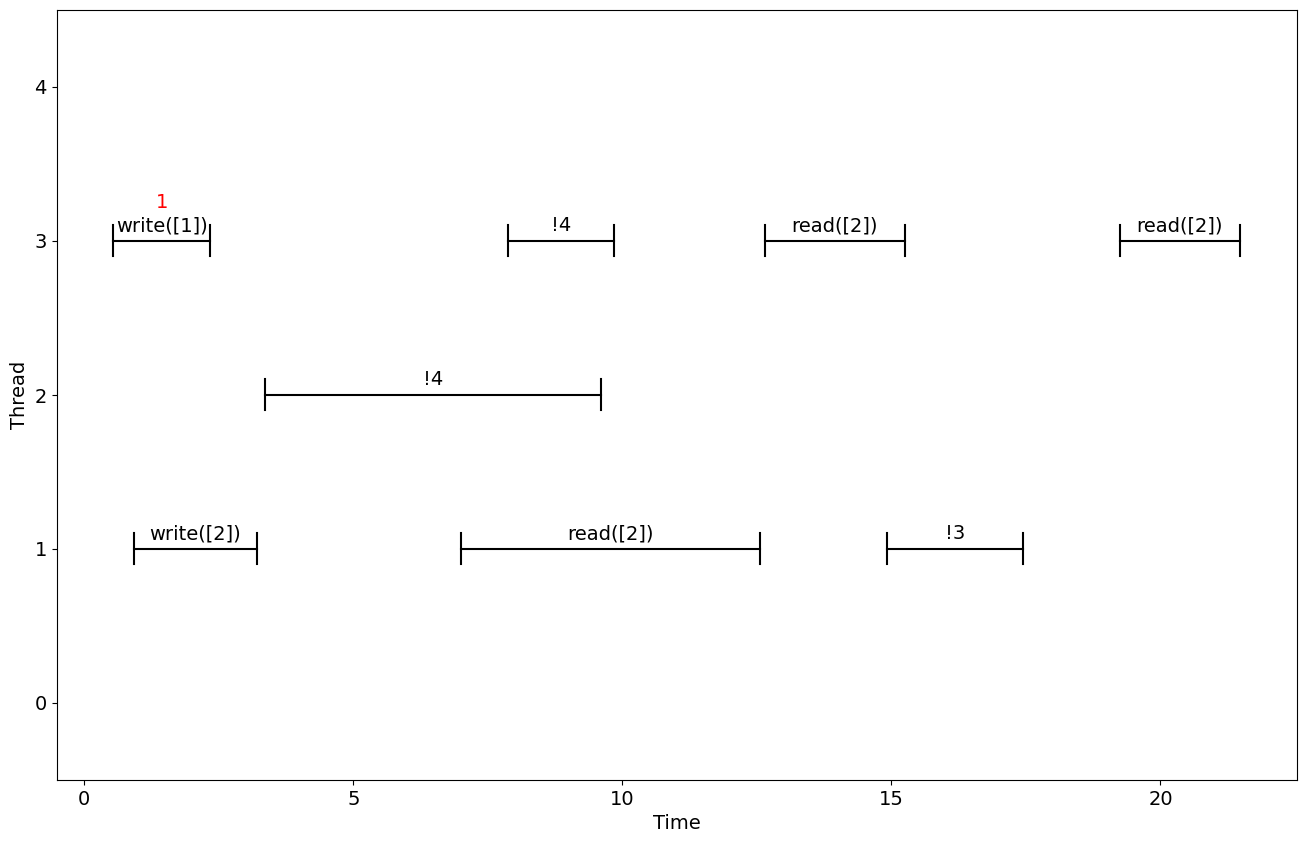

<IPython.core.display.Javascript object>

In [49]:
i = 0
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
print(linearize_io(testcase, verbose=True))
# sol = linearize_generic(testcase, StateIO())
# visualize_history(testcase)
visualize_history(testcase)

# Shared log
# append - appends an element to the list
# read - reads the entire list

a = SharedLog()

---a5----          ---r[2,5,6]---
-a2-  ----a6---



Testcase 18 is True


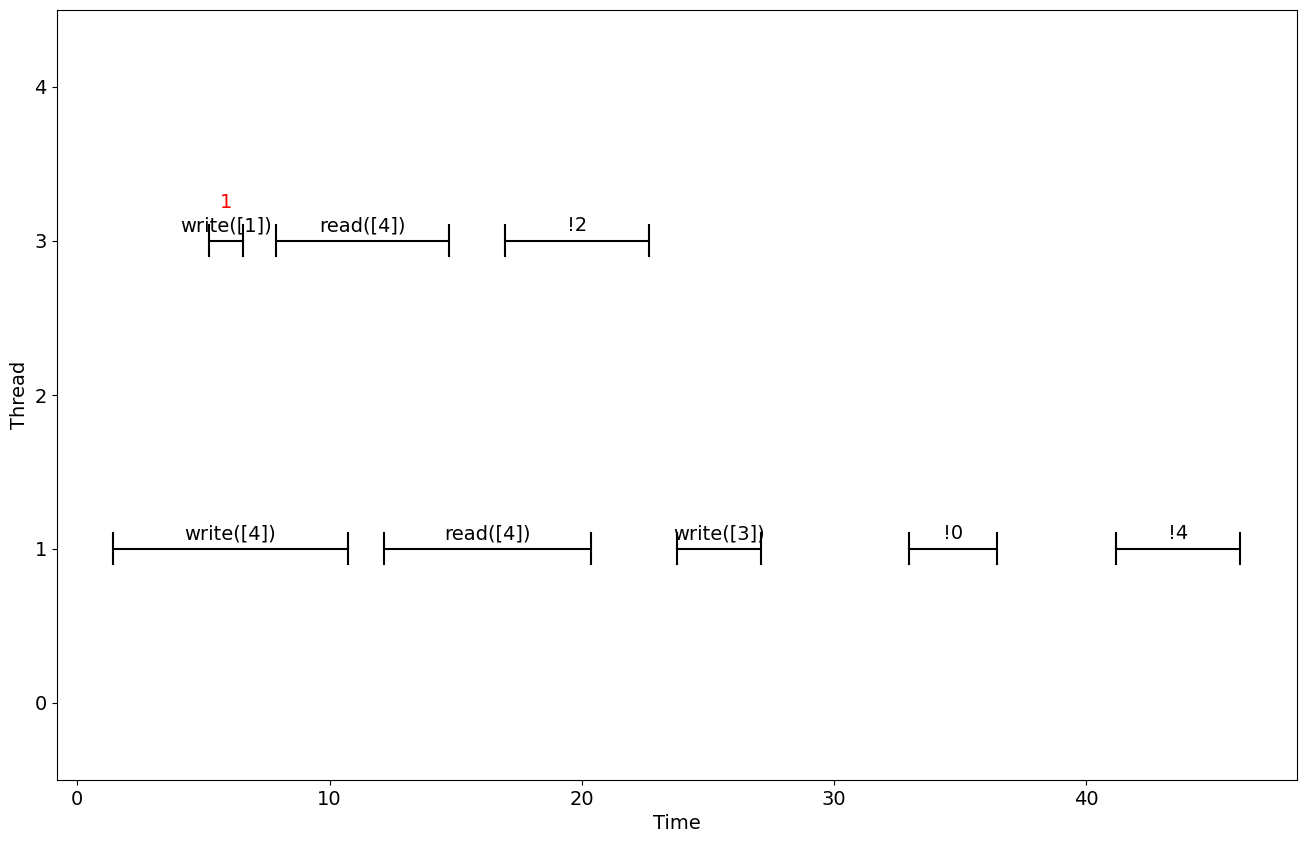

<IPython.core.display.Javascript object>

In [32]:
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
visualize_history(testcase)

Testcase 0 is True
[[1], [2]]
{'!4 (3.36 - 9.6)': {2}, '!4 (7.87 - 9.84)': {2}, '!3 (14.91 - 17.45)': {2}}
True


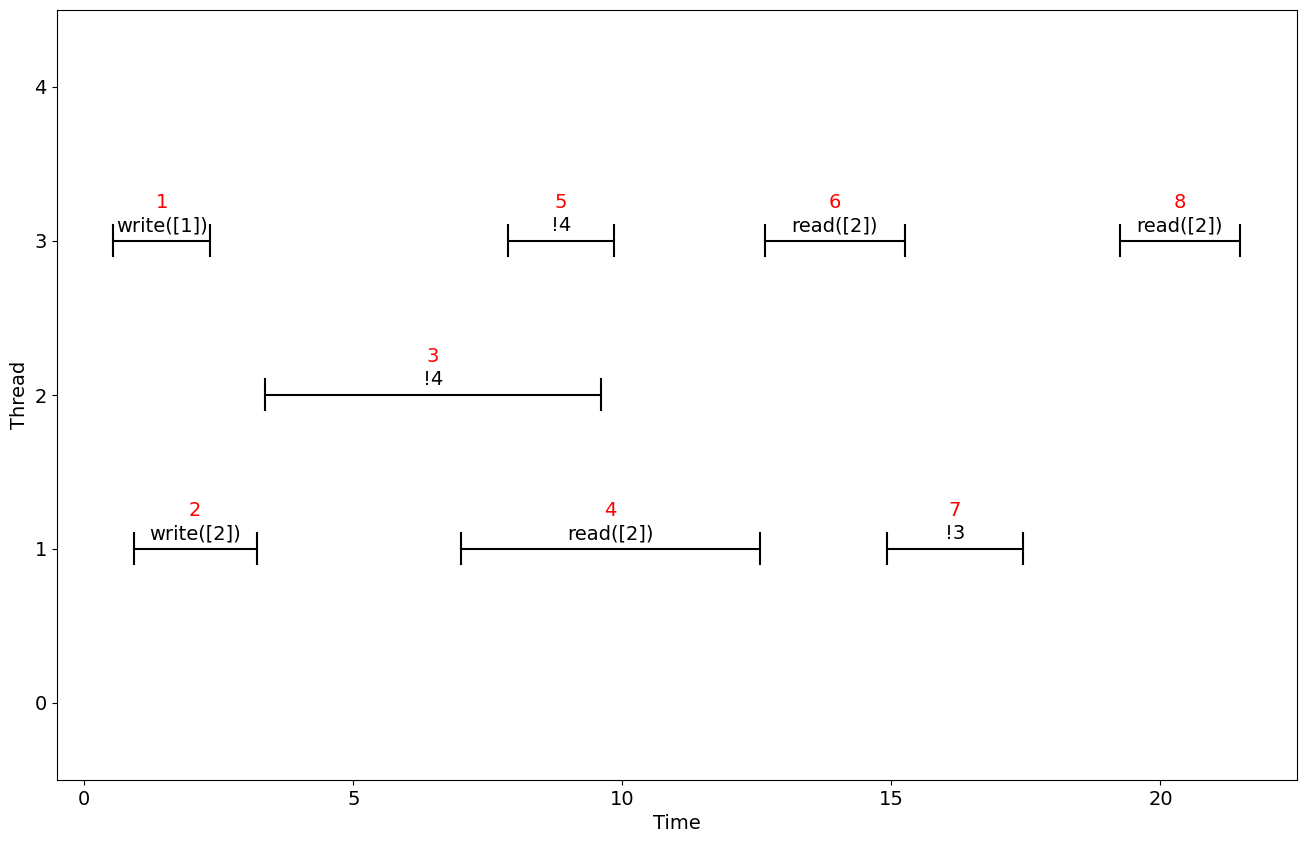

Testcase 11 is True
[[4, 2, 1]]
{'!2 (10.88 - 16.67)': {1, 4}, '!0 (15.98 - 21.82)': {1, 2, 4}, '!3 (21.86 - 30.88)': {1, 4}}
True


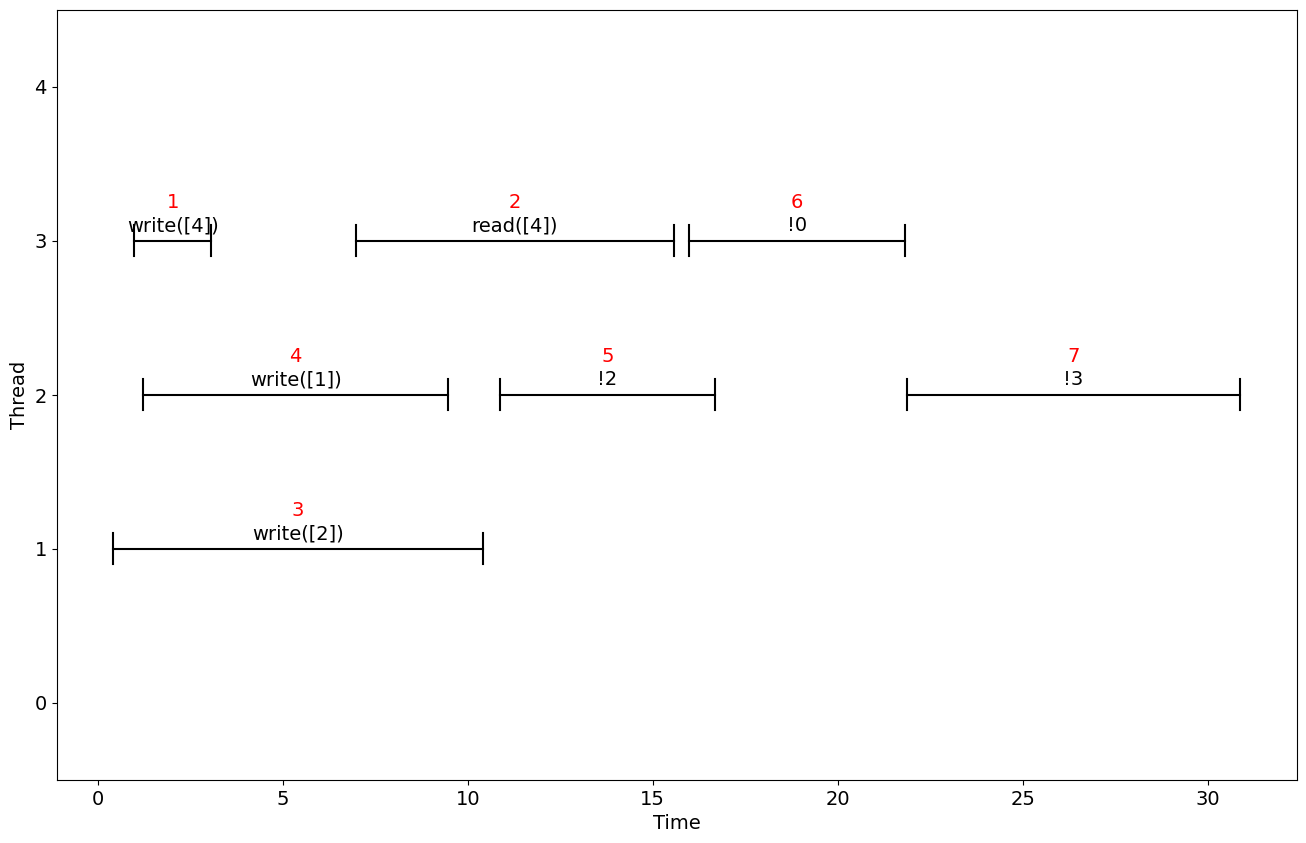

Testcase 18 is True
[[1], [4], [3]]
{'!2 (16.96 - 22.67)': {4}, '!0 (32.98 - 36.46)': {3}, '!4 (41.19 - 46.1)': {3}}
True


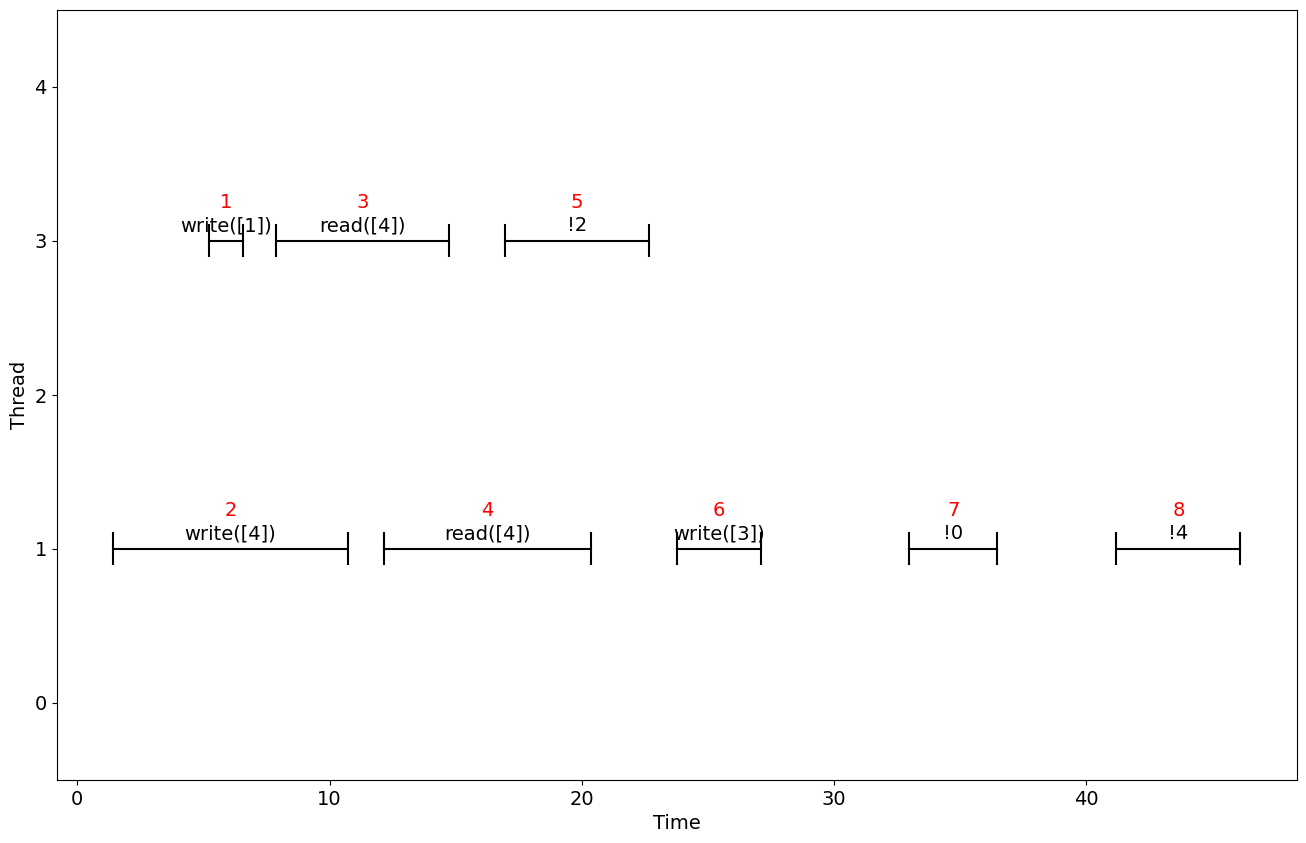

Testcase 19 is False
False


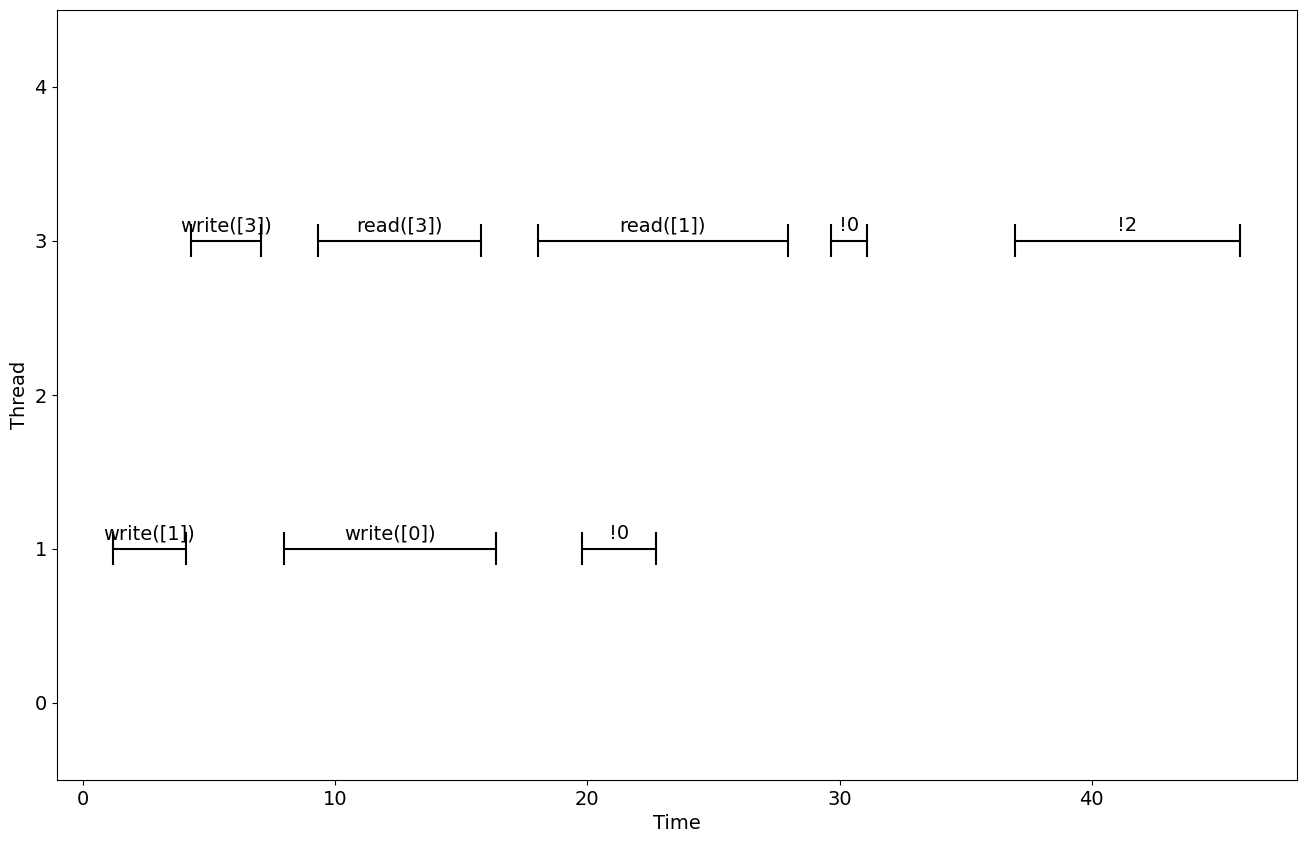

Testcase 23 is False
False


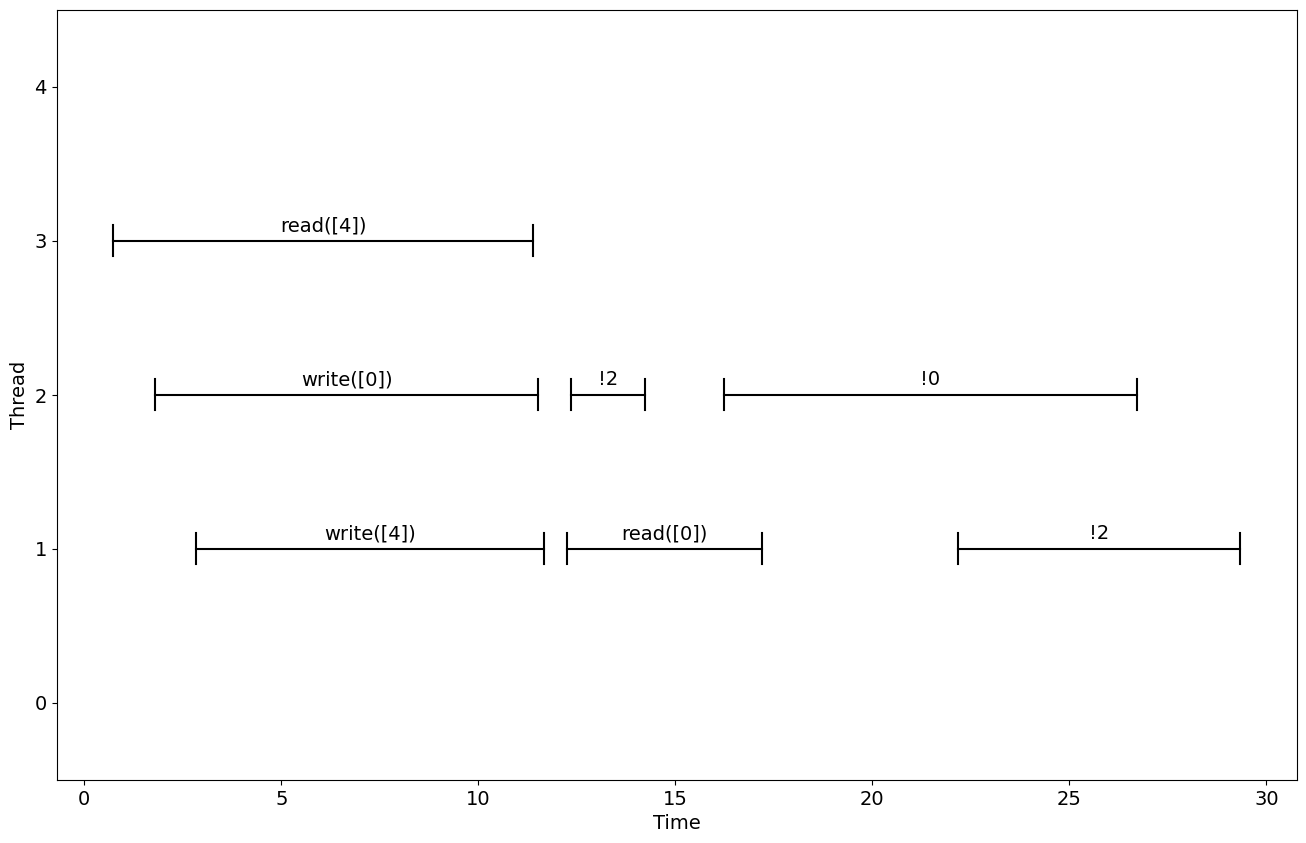

Testcase 38 is True
[[2], [3], [0]]
{'!1 (30.46 - 39.87)': {0}, '!1 (44.64 - 54.69)': {0}, '!1 (56.94 - 67.03)': {0}}
True


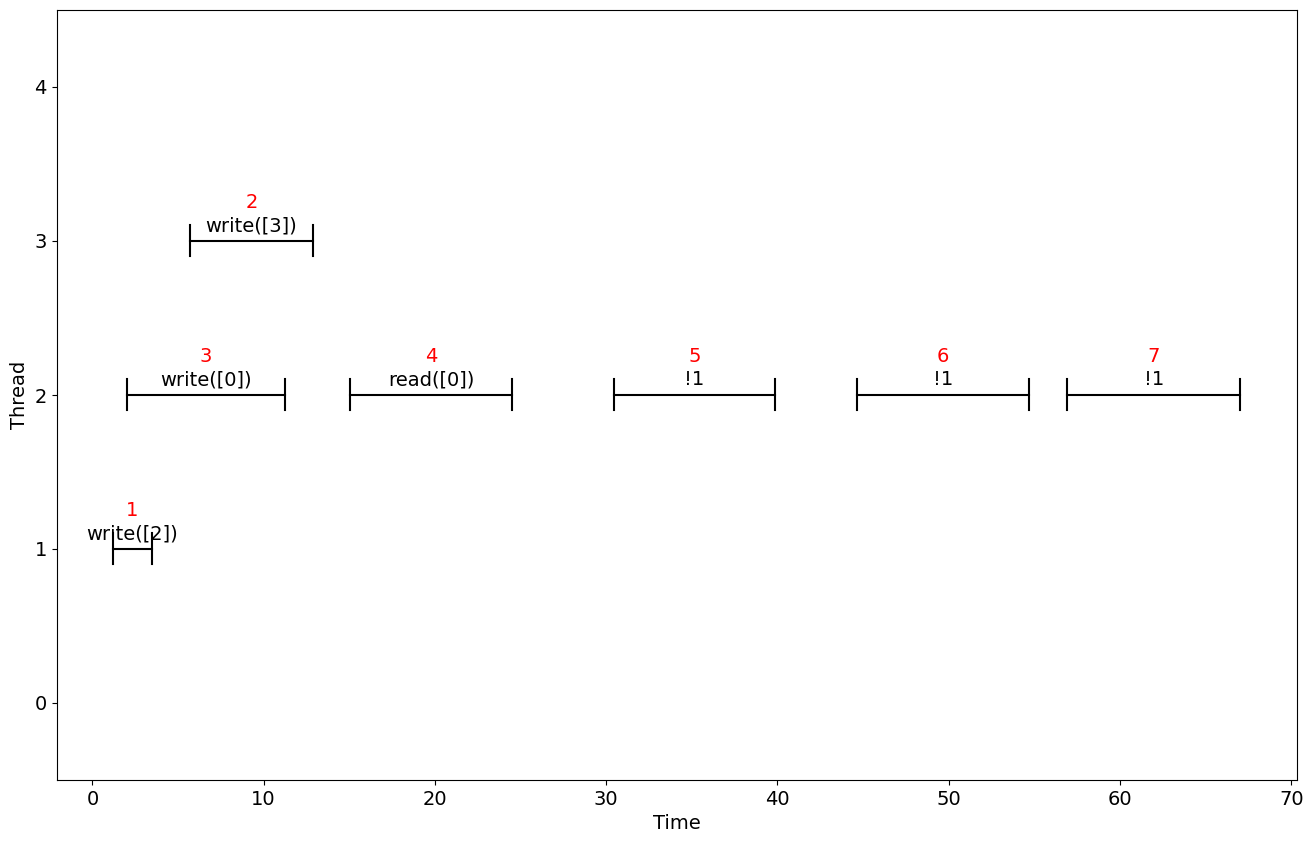

Testcase 54 is True
[[1, 3], [0], [4]]
{'!1 (30.31 - 32.46)': {4}, '!0 (36.06 - 45.15)': {4}, '!0 (48.62 - 50.34)': {4}}
True


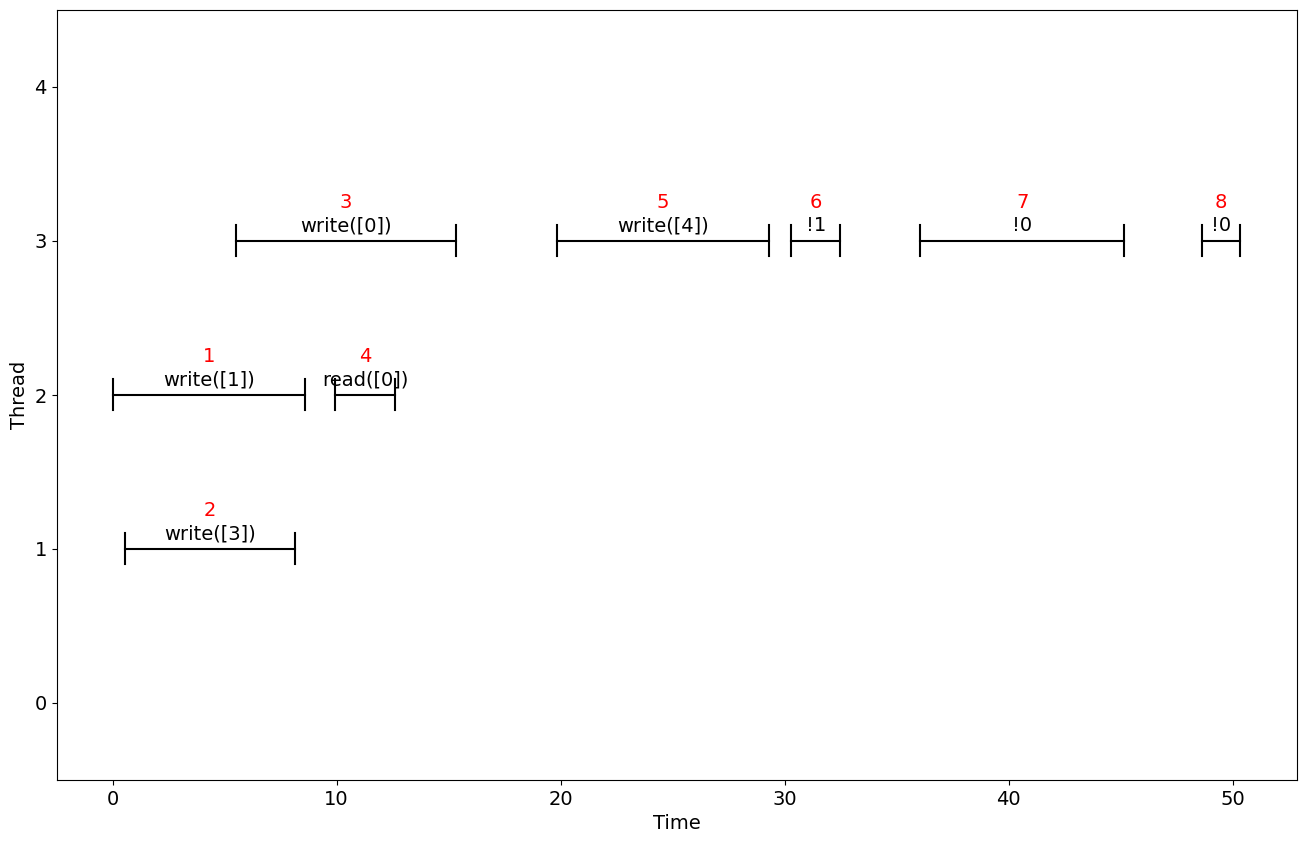

Testcase 81 is False
False


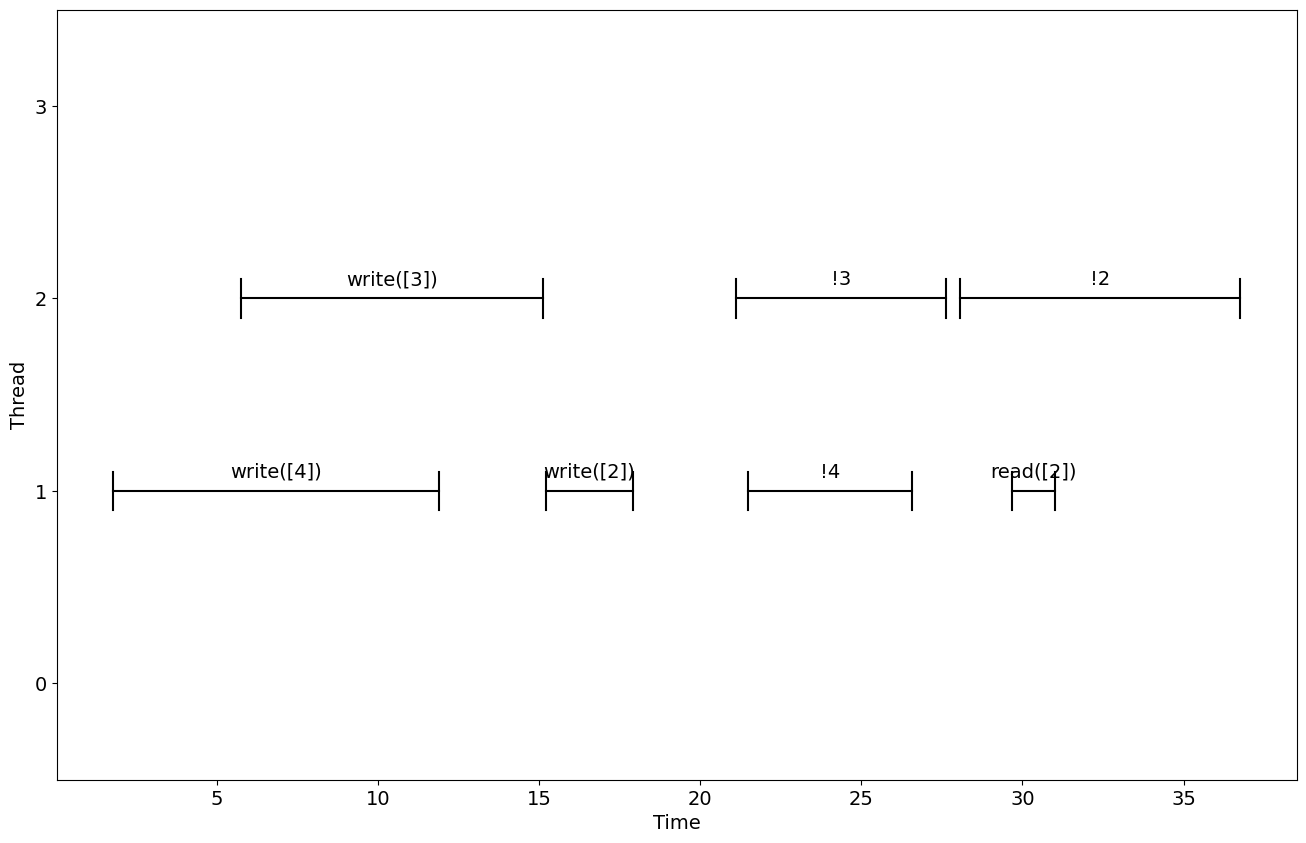

Testcase 103 is True
[[1, 2], [3, 2]]
{'!2 (14.01 - 16.98)': {3}, '!1 (14.1 - 19.24)': {2, 3}, '!4 (19.76 - 25.24)': {3}}
True


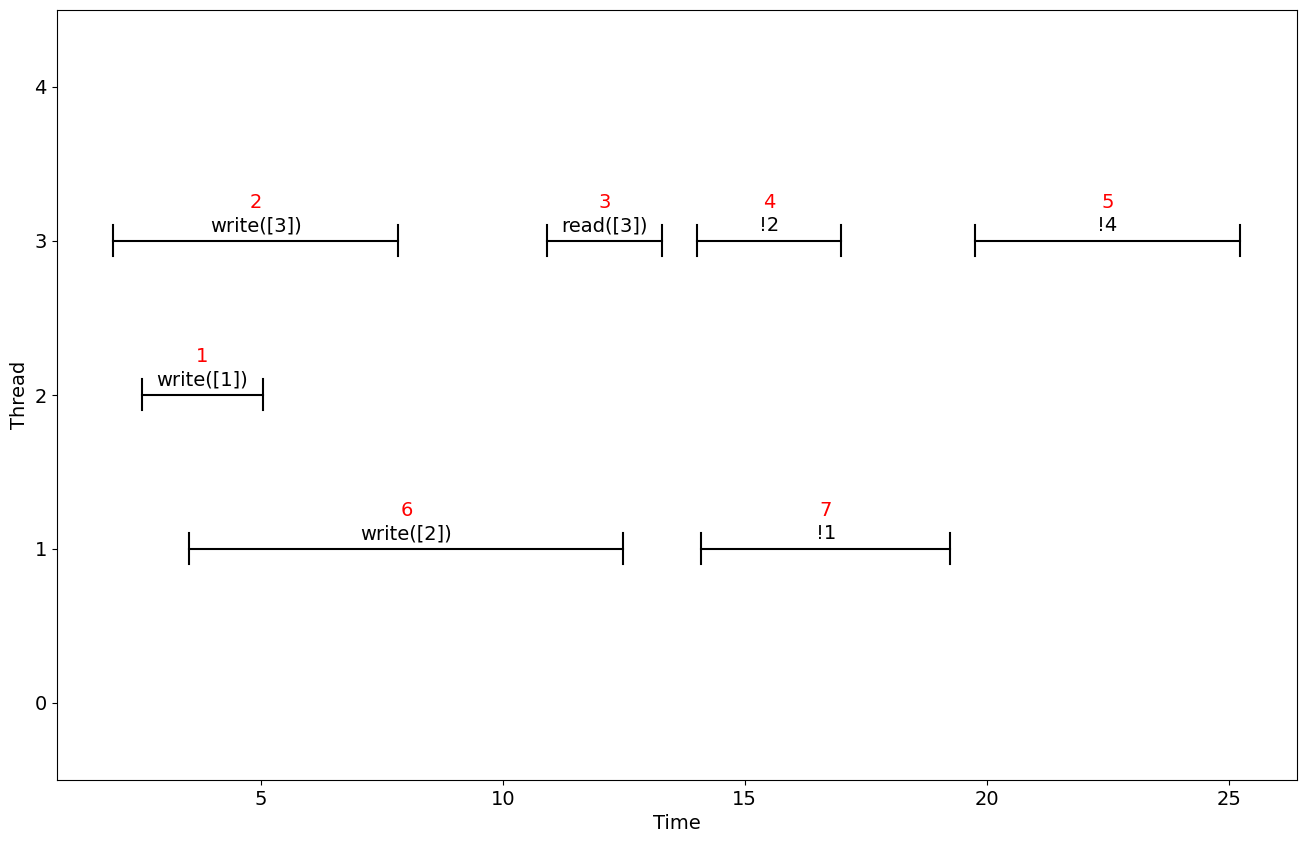

Testcase 107 is True
[[4], [1], [3]]
{'!0 (14.16 - 16.61)': {3}, '!4 (18.91 - 23.3)': {3}, '!2 (24.28 - 34.09)': {3}}
True


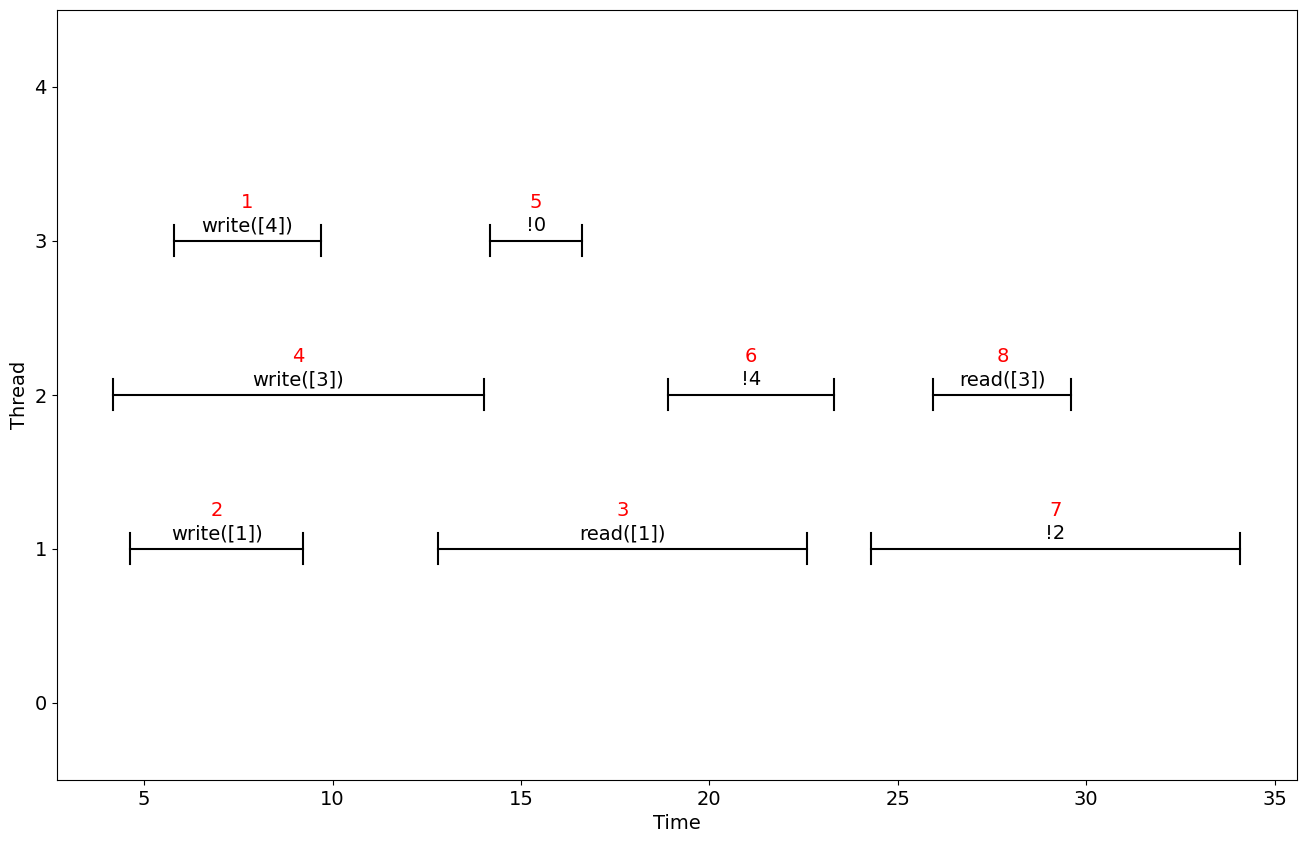

<IPython.core.display.Javascript object>

In [56]:
for wrong_test in no[:10]:
    testcase, res = copy.deepcopy(test[wrong_test])
    print(f"Testcase {wrong_test} is {res}")
    print(linearize_io(testcase, verbose=True))
    visualize_history(testcase)